In [1]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

/opt/anaconda3/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [3]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도','주차대수',
                    'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
                    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
                    'k-135㎡초과', '건축면적','latitude', 'longitude',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

df.head()

,id,아파트명,계약년월,계약일,층,구,동,건축년도,주차대수,k-전체동수,...,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target,apt_mean_target,mean_target,전용면적,계약년
0,0,개포6차우성,2017-12-01,8,3,강남구,개포동,1987,262.0,8.0,...,0,57,0,6.609733,0,124000.0,104403.465347,119240.517241,79.97,2017
1,1,개포6차우성,2017-12-01,22,4,강남구,개포동,1987,262.0,8.0,...,0,57,0,6.609733,0,123500.0,104403.465347,119240.517241,79.97,2017
2,2,개포6차우성,2017-12-01,28,5,강남구,개포동,1987,262.0,8.0,...,0,57,0,6.609733,0,91500.0,104403.465347,86362.500000,54.98,2017
3,3,개포6차우성,2018-01-01,3,4,강남구,개포동,1987,262.0,8.0,...,0,57,0,6.609733,0,130000.0,104403.465347,119240.517241,79.97,2018
4,4,개포6차우성,2018-01-01,8,2,강남구,개포동,1987,262.0,8.0,...,0,57,0,6.609733,0,117000.0,104403.465347,119240.517241,79.97,2018


# 지역별 chunk 나누기

In [5]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# 올해 + 1년 전 우리 구 평균 부동산 가격 피쳐 만들기

In [6]:
from IPython.display import display

for region in regions:
    chunk = chunks[region]

    year_target_means = {}

    for year in range(2007, 2024):
        this_year_target_mean = chunk.loc[(chunk['계약년'] == year) & (chunk['is_test'] == 0) ,'target'].mean()
        chunk.loc[(chunk['계약년'] == year) , '올해 지역 평균'] =  this_year_target_mean
        year_target_means[year] = this_year_target_mean

        if year == 2007:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = this_year_target_mean
        else:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = year_target_means[year-1]
    
    chunks[region] = chunk

# 모델 학습

In [10]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()
trained_models = {}

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id', '전용면적', '계약일', '층', '건축년도','주차대수',
                    'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
                    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
                    'k-135㎡초과', '건축면적','latitude', 'longitude',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,

                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )
    
    trained_models[region] = final_model

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 15867	valid_1's rmse: 49488.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 14098.9	valid_1's rmse: 16348.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 14104	valid_1's rmse: 78074.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 23556.8	valid_1's rmse: 91840.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	training's rmse: 36938	valid_1's rmse: 54422.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 42927.9	valid_1's rmse: 33685.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	training's rm

  4%|▍         | 1/25 [00:03<01:24,  3.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	training's rmse: 9733.41	valid_1's rmse: 19702.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 4198.3	valid_1's rmse: 7226.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	training's rmse: 4902.37	valid_1's rmse: 24353.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	training's rmse: 6274.65	valid_1's rmse: 42701.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	training's rmse: 12399	valid_1's rmse: 19591
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 12317.1	valid_1's rmse: 16131.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	training's r

  8%|▊         | 2/25 [00:06<01:17,  3.39s/it]

Early stopping, best iteration is:
[24]	training's rmse: 11443.9	valid_1's rmse: 11036.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	training's rmse: 2404.38	valid_1's rmse: 6730.27
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	training's rmse: 2526.93	valid_1's rmse: 3489.66
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 2851.92	valid_1's rmse: 31695.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	training's rmse: 5915.51	valid_1's rmse: 17632.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	training's rmse: 12139.3	valid_1's rmse: 9494.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	training's rmse: 9400.33	valid_1's rmse: 9009.36
Training until val

 12%|█▏        | 3/25 [00:09<01:05,  2.97s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	training's rmse: 4839.47	valid_1's rmse: 12515.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	training's rmse: 4353.24	valid_1's rmse: 5685.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	training's rmse: 7430.63	valid_1's rmse: 39761.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	training's rmse: 11380.4	valid_1's rmse: 25719
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	training's rmse: 12422.8	valid_1's rmse: 10291.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	training's rmse: 12915.9	valid_1's rmse: 10741.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	training's

 16%|█▌        | 4/25 [00:12<01:08,  3.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	training's rmse: 3736.46	valid_1's rmse: 9307.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	training's rmse: 2802.64	valid_1's rmse: 3750.53
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	training's rmse: 2980.96	valid_1's rmse: 36727.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	training's rmse: 8269.09	valid_1's rmse: 12312.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	training's rmse: 9289.97	valid_1's rmse: 12084.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	training's rmse: 11038.1	valid_1's rmse: 9854.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	traini

 20%|██        | 5/25 [00:16<01:04,  3.21s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 6632.88	valid_1's rmse: 21906.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 5374.02	valid_1's rmse: 7724.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[34]	training's rmse: 6340.71	valid_1's rmse: 49035.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 11152.2	valid_1's rmse: 46979.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	training's rmse: 14417.2	valid_1's rmse: 26458.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	training's rmse: 15671.1	valid_1's rmse: 16350.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[3]	trainin

 24%|██▍       | 6/25 [00:18<00:57,  3.02s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	training's rmse: 2634.55	valid_1's rmse: 9803.65
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 3847.84	valid_1's rmse: 5883.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	training's rmse: 3220.66	valid_1's rmse: 33202.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 7544.21	valid_1's rmse: 16251.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training's rmse: 12534.8	valid_1's rmse: 15176
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	training's rmse: 8018.44	valid_1's rmse: 10740.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training

 28%|██▊       | 7/25 [00:21<00:52,  2.94s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 2183.24	valid_1's rmse: 7347.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 1903.01	valid_1's rmse: 12694.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 3153.61	valid_1's rmse: 24568.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training's rmse: 10958.4	valid_1's rmse: 17464.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[8]	training's rmse: 12872.4	valid_1's rmse: 9556.34
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training's rmse: 11285.7	valid_1's rmse: 8837.64
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	training

 32%|███▏      | 8/25 [00:23<00:45,  2.67s/it]

Early stopping, best iteration is:
[62]	training's rmse: 6614.46	valid_1's rmse: 4354.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	training's rmse: 8463.79	valid_1's rmse: 13675.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	training's rmse: 2675.78	valid_1's rmse: 8591.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	training's rmse: 2668.37	valid_1's rmse: 3891.41
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	training's rmse: 9513.28	valid_1's rmse: 34390.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	training's rmse: 12592.6	valid_1's rmse: 23905.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 10008.5	valid_1's rmse: 15077.2
Training until vali

 36%|███▌      | 9/25 [00:27<00:46,  2.89s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 2693.97	valid_1's rmse: 6980.49
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 2357.36	valid_1's rmse: 6522.99
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	training's rmse: 8064.18	valid_1's rmse: 27775.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 6683.32	valid_1's rmse: 14922.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	training's rmse: 6570.06	valid_1's rmse: 11637.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	training's rmse: 8815.49	valid_1's rmse: 8521.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	trainin

 40%|████      | 10/25 [00:29<00:43,  2.91s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	training's rmse: 4535.31	valid_1's rmse: 9557.22
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	training's rmse: 4262.03	valid_1's rmse: 6760.01
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 4399.36	valid_1's rmse: 36923.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 11363.6	valid_1's rmse: 23782.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	training's rmse: 13091.7	valid_1's rmse: 14505.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	training's rmse: 15375.3	valid_1's rmse: 16319.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	trainin

 44%|████▍     | 11/25 [00:32<00:40,  2.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	training's rmse: 6446.16	valid_1's rmse: 16037.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 5527.88	valid_1's rmse: 7017.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[12]	training's rmse: 9133.89	valid_1's rmse: 57765.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	training's rmse: 12885	valid_1's rmse: 28819
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	training's rmse: 15831	valid_1's rmse: 15747.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[9]	training's rmse: 20700.9	valid_1's rmse: 20080.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	training's rm

 48%|████▊     | 12/25 [00:35<00:38,  2.95s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 7402.5	valid_1's rmse: 16623.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	training's rmse: 6764.13	valid_1's rmse: 6420.24
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 6524.09	valid_1's rmse: 50803.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	training's rmse: 13461	valid_1's rmse: 32207.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	training's rmse: 18328	valid_1's rmse: 18885.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 16736	valid_1's rmse: 16722.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	training's rms

 52%|█████▏    | 13/25 [00:38<00:35,  2.96s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 5653.73	valid_1's rmse: 10335.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 4503	valid_1's rmse: 7793.97
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 5576.47	valid_1's rmse: 43594.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	training's rmse: 12321.2	valid_1's rmse: 22762.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 14357.7	valid_1's rmse: 13674.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training's rmse: 17397.6	valid_1's rmse: 12680.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	training's

 56%|█████▌    | 14/25 [00:41<00:30,  2.81s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 20924.7	valid_1's rmse: 47086.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[82]	training's rmse: 11137.8	valid_1's rmse: 13973.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 12526.4	valid_1's rmse: 101158
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	training's rmse: 29415.5	valid_1's rmse: 64427.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	training's rmse: 37823.6	valid_1's rmse: 51601.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	training's rmse: 43660.8	valid_1's rmse: 40621.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	trainin

 60%|██████    | 15/25 [00:44<00:28,  2.82s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	training's rmse: 7937.81	valid_1's rmse: 18462.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	training's rmse: 6929.57	valid_1's rmse: 5705.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 6367.84	valid_1's rmse: 78073.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 17475.7	valid_1's rmse: 34364
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 19510.9	valid_1's rmse: 17929.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	training's rmse: 18060.6	valid_1's rmse: 15167.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	training

 64%|██████▍   | 16/25 [00:47<00:25,  2.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	training's rmse: 3992.03	valid_1's rmse: 8186.24
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 3579.14	valid_1's rmse: 4367.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	training's rmse: 3575.48	valid_1's rmse: 35868.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	training's rmse: 8079.99	valid_1's rmse: 26279.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[11]	training's rmse: 13227.8	valid_1's rmse: 10493.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	training's rmse: 12199.5	valid_1's rmse: 13256.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	training

 68%|██████▊   | 17/25 [00:50<00:24,  3.10s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[24]	training's rmse: 9506.14	valid_1's rmse: 29774
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	training's rmse: 8408.44	valid_1's rmse: 11300.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	training's rmse: 7566.21	valid_1's rmse: 41173.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 13386.4	valid_1's rmse: 75984.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 21463.3	valid_1's rmse: 31094.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[27]	training's rmse: 22518.8	valid_1's rmse: 18223.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	training

 72%|███████▏  | 18/25 [00:54<00:22,  3.18s/it]

Early stopping, best iteration is:
[25]	training's rmse: 20888.6	valid_1's rmse: 18580.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 7376.2	valid_1's rmse: 15333.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	training's rmse: 4810.16	valid_1's rmse: 8583.77
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	training's rmse: 5736.67	valid_1's rmse: 27461.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	training's rmse: 6599.06	valid_1's rmse: 58608.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 8882.2	valid_1's rmse: 23087.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 16175.9	valid_1's rmse: 27105
Training until valida

 76%|███████▌  | 19/25 [00:56<00:18,  3.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 4437.27	valid_1's rmse: 15753.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	training's rmse: 5269.1	valid_1's rmse: 11089.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	training's rmse: 5081.09	valid_1's rmse: 48935.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	training's rmse: 12302.7	valid_1's rmse: 47524.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 15331.4	valid_1's rmse: 16082.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 15481.3	valid_1's rmse: 15102.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	trainin

 80%|████████  | 20/25 [00:59<00:14,  2.99s/it]

Early stopping, best iteration is:
[28]	training's rmse: 14876.9	valid_1's rmse: 13659.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 10378.1	valid_1's rmse: 73781.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	training's rmse: 9957.88	valid_1's rmse: 19408.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	training's rmse: 9882.61	valid_1's rmse: 101337
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	training's rmse: 30128	valid_1's rmse: 75100.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[14]	training's rmse: 39826.4	valid_1's rmse: 39010.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	training's rmse: 33079	valid_1's rmse: 21458.9
Training until validat

 84%|████████▍ | 21/25 [01:02<00:11,  2.85s/it]

Early stopping, best iteration is:
[42]	training's rmse: 24091.8	valid_1's rmse: 24782.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[25]	training's rmse: 3513.88	valid_1's rmse: 9052.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	training's rmse: 3578.39	valid_1's rmse: 6794.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 3429.6	valid_1's rmse: 24972.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 5991.43	valid_1's rmse: 24359.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	training's rmse: 8012.6	valid_1's rmse: 7134.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	training's rmse: 8354.77	valid_1's rmse: 11752.8
Training until vali

 88%|████████▊ | 22/25 [01:04<00:08,  2.72s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 5501.5	valid_1's rmse: 12597.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 4704.16	valid_1's rmse: 10490.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	training's rmse: 4928.83	valid_1's rmse: 35197.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 8616.77	valid_1's rmse: 29218.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 10229	valid_1's rmse: 13218.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 14825	valid_1's rmse: 13208.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[15]	training's 

 92%|█████████▏| 23/25 [01:06<00:05,  2.58s/it]

Early stopping, best iteration is:
[40]	training's rmse: 9898.15	valid_1's rmse: 6584.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	training's rmse: 5024.26	valid_1's rmse: 14761
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	training's rmse: 5686.67	valid_1's rmse: 16561.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[209]	training's rmse: 3806.38	valid_1's rmse: 36726.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 8329.73	valid_1's rmse: 18786.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	training's rmse: 12344.4	valid_1's rmse: 12852.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 11791.4	valid_1's rmse: 12662.9
Training until val

 96%|█████████▌| 24/25 [01:09<00:02,  2.56s/it]

Early stopping, best iteration is:
[78]	training's rmse: 9515.61	valid_1's rmse: 12593.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	training's rmse: 13096	valid_1's rmse: 22100.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[28]	training's rmse: 3125.41	valid_1's rmse: 6486.08
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 2560.26	valid_1's rmse: 7804.37
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	training's rmse: 3113.62	valid_1's rmse: 26053.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	training's rmse: 5774.51	valid_1's rmse: 16143.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	training's rmse: 10452.8	valid_1's rmse: 11952.9
Training until vali

100%|██████████| 25/25 [01:11<00:00,  2.88s/it]

Early stopping, best iteration is:
[33]	training's rmse: 6815.42	valid_1's rmse: 11269.6


# 결과 확인

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

7709.681676582625


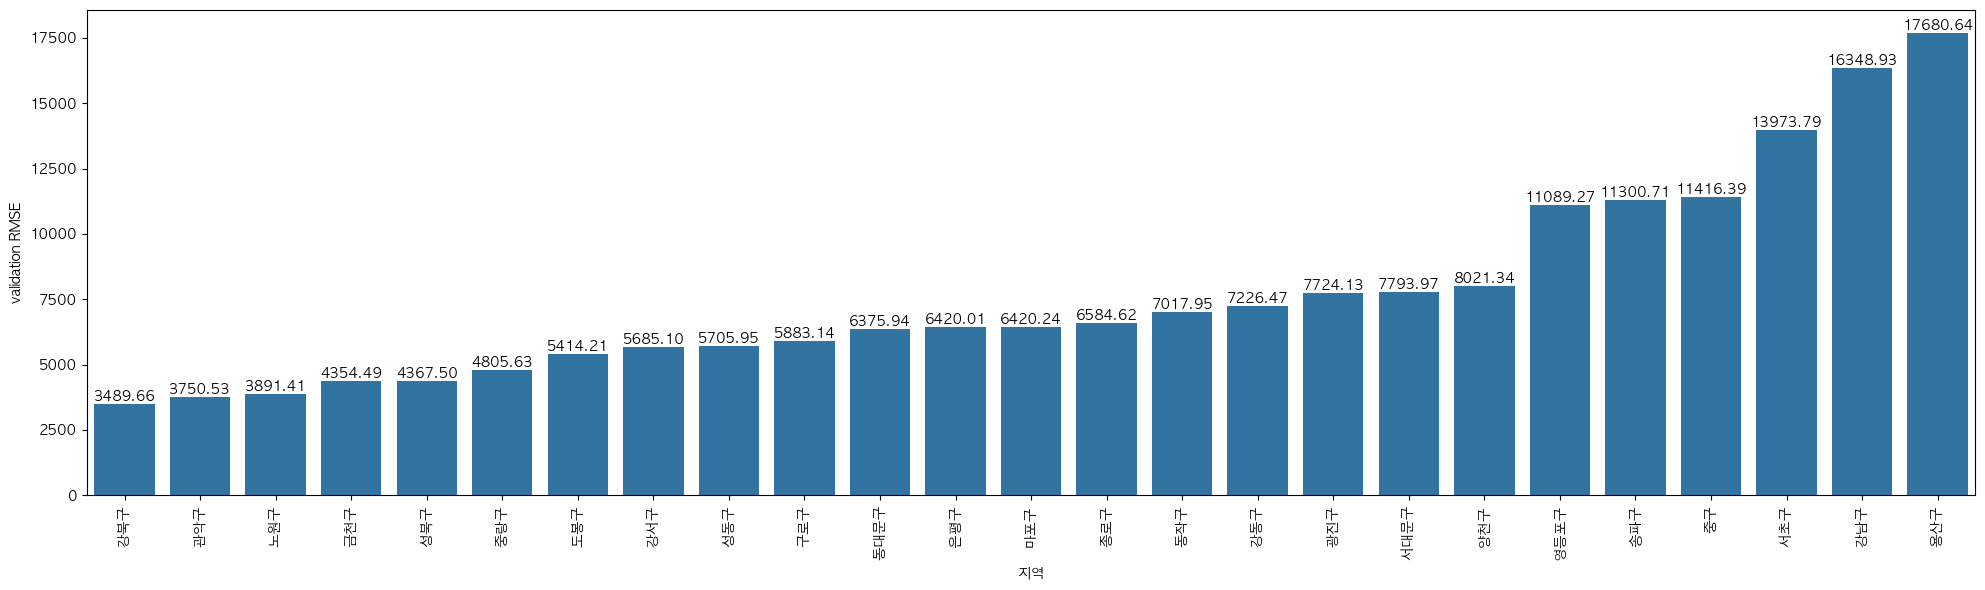

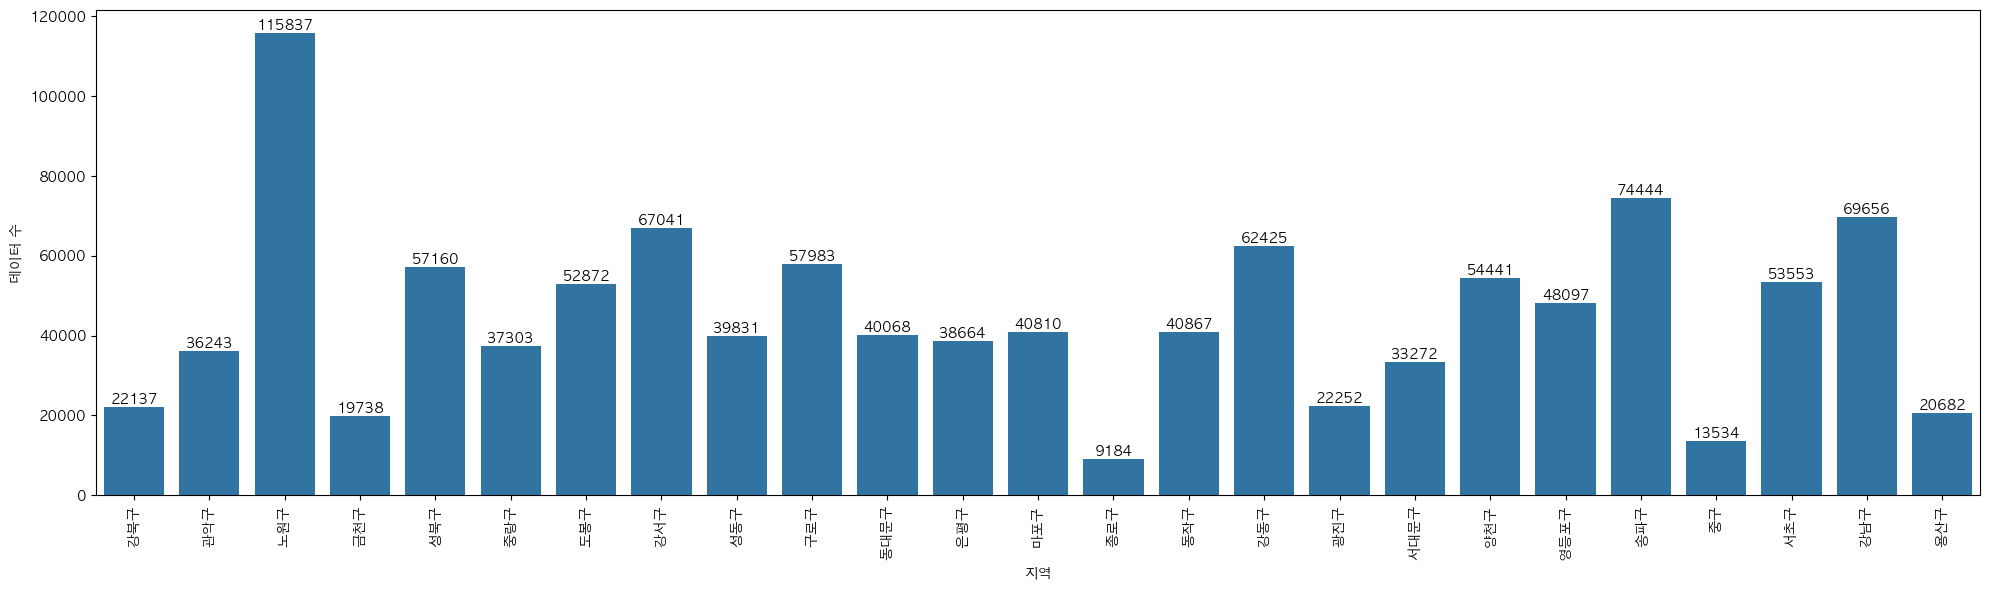

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [85]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_parking_log_transform.csv', index=False)

,id,target
1118822,1118822,179190.872400
1118823,1118823,265035.037241
1118824,1118824,305960.674321
1118825,1118825,250985.416208
1118826,1118826,189059.763100
...,...,...
1128089,1128089,68760.003756
1128090,1128090,67836.781866
1128091,1128091,79123.667332
1128092,1128092,67846.916674


id        0
target    0
dtype: int64


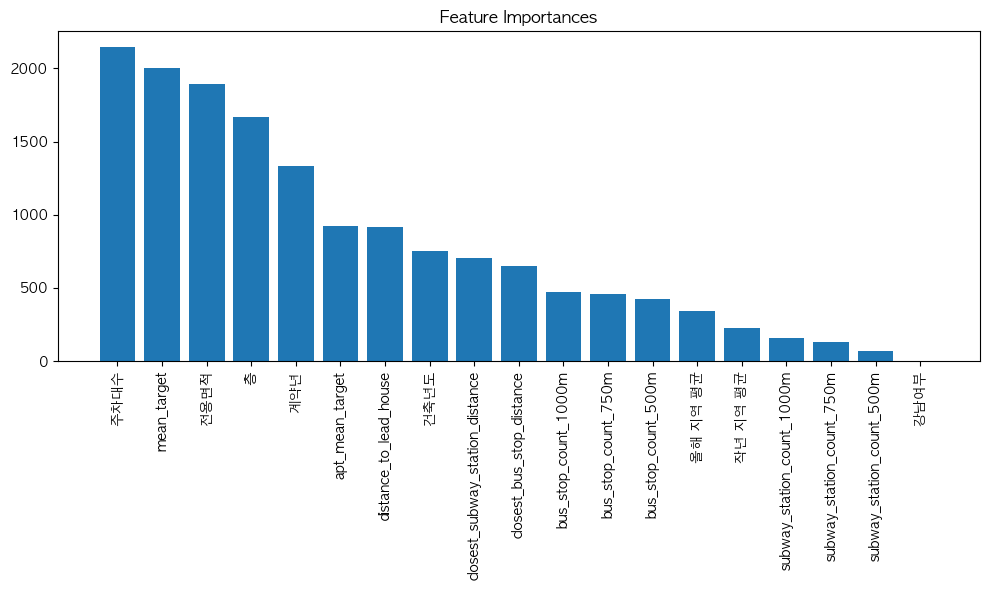

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

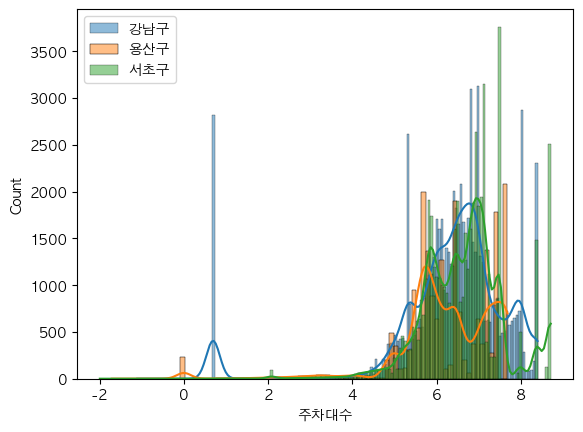

In [83]:
caution_regions = ['강남구', '용산구', '서초구']

for region in caution_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()

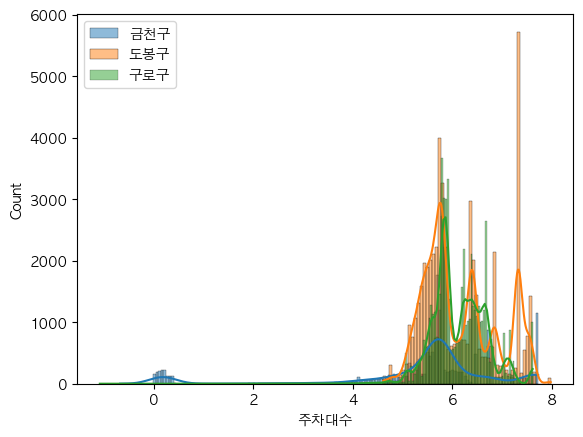

In [84]:
good_regions = ['금천구', '도봉구', '구로구']

for region in good_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()